# Classify audio effects on guitar samples

## 0. Import, config and setup

In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import sklearn
from joblib import dump, load

In [2]:
# Setting up variables used for extracting features
# and calculating the length of the two feature sets
samplerate = 44100
sample_len = 2*samplerate
n_mfcc = 13
hop_len = 512
segment_len = int(np.ceil(sample_len/hop_len))
mfcc_len = segment_len
spectral_bandwidth_len = segment_len
spectral_flatness_len = 1
feature_1_len = mfcc_len*n_mfcc + spectral_bandwidth_len + spectral_flatness_len
feature_2_len = mfcc_len*2 + spectral_bandwidth_len + spectral_flatness_len
print("Feature set 1 size: %i" % feature_1_len)
print("Feature set 2 size: %i" % feature_2_len)

Feature set 1 size: 2423
Feature set 2 size: 520


## 0.a Select feature set
Select the feature set used for training here. Both feature sets are described as feature set 1 and feature set 2 in the report,

In [3]:
# Select feature set 1 or 2
feature_set_nr = 1
if not 0 < feature_set_nr < 3:
    raise ValueError("Select feature 1 or 2")
if feature_set_nr == 1:
    feature_len = feature_1_len
elif feature_set_nr == 2:
    feature_len = feature_2_len
    
# Create array of strings for the class names
classes = ['Chorus','Distortion','EQ','FeedbackDelay','Flanger','NoFX']

## 1. Import and prepare data
This section does not need to be run if we are loading the precalculated features from .csv in 2.b

In [18]:
# Get paths to all the audio files from the labeled directories
fileswchorus = os.listdir('./DataSet/Samples/Chorus')
fileswdistortion = os.listdir('./DataSet/Samples/Distortion')
filesweq = os.listdir('./DataSet/Samples/EQ')
fileswdelay = os.listdir('./DataSet/Samples/FeedbackDelay')
fileswflanger = os.listdir('./DataSet/Samples/Flanger')
fileswnofx = os.listdir('./DataSet/Samples/NoFX')

# Calculate the number of samples in the dataset
n_data = len(fileswchorus)+len(fileswdistortion)+len(filesweq)+len(fileswdelay)+len(fileswflanger)+len(fileswnofx)
print("Number of samples: %i" % n_data)

# Create label vector for the classes
labels = np.zeros(n_data)
features = np.zeros((n_data, feature_len))

Number of samples: 9360


## 2. Extract features
This block extracts the features as selected earlier. We are extracting features for over 5 hours of audio data, so it can take up to 10 minutes. Consider loading the features from the .csv file in section 2.b

In [ ]:
from IPython.display import clear_output
start_time = time.time()
count = 0

def extract_features(filename, count=0):
    # Extract features from input audio file and output them as a vector
    signal, dummy = librosa.load(filename, samplerate, mono=True)
    # Extract MFCC
    mfccs = librosa.feature.mfcc(signal, samplerate, n_mfcc=n_mfcc, hop_length=hop_len)
    # Extract spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(signal, samplerate).flatten()
    # Extract spectral flatness
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(signal).flatten())
    if feature_set_nr == 1:
        output = np.append(np.concatenate((mfccs.flatten(), spectral_bandwidth)),spectral_flatness)
    elif feature_set_nr == 2:
        mfccs_mean = np.mean(mfccs,0).flatten()
        mfccs_std = np.std(mfccs,0).flatten()
        output = np.append(np.concatenate((mfccs_mean, mfccs_std, spectral_bandwidth)),spectral_flatness)
    clear_output(wait=True)
    print("%i/%i samples processed" % (count, n_data))
    return output
    
idx = 0
    
for x in fileswchorus:
    count = count+1
    output = extract_features('./DataSet/Samples/Chorus/' + x, count)
    features[idx,:] = output
    labels[idx] = 0
    idx = idx+1
    
for x in fileswdistortion:
    count = count+1
    output = extract_features('./DataSet/Samples/Distortion/' + x, count)
    features[idx,:] = output
    labels[idx] = 1
    idx = idx+1    
        
for x in filesweq:
    count = count+1
    output = extract_features('./DataSet/Samples/EQ/' + x, count)
    features[idx,:] = output
    labels[idx] = 2
    idx = idx+1    
    
for x in fileswdelay:
    count = count+1
    output = extract_features('./DataSet/Samples/FeedbackDelay/' + x, count)
    features[idx,:] = output
    labels[idx] = 3
    idx = idx+1    

for x in fileswflanger:
    count = count+1
    output = extract_features('./DataSet/Samples/Flanger/' + x, count)
    features[idx,:] = output
    labels[idx] = 4
    idx = idx+1    

for x in fileswnofx:
    count = count+1
    output = extract_features('./DataSet/Samples/NoFX/' + x, count)
    features[idx,:] = output
    labels[idx] = 5
    idx = idx+1    

labels = pd.DataFrame(labels)
labels.columns = ['labels']
labels = labels['labels']
    
print("Feature extraction done")
print("Took %d seconds" % (time.time() - start_time))

### 2.a Save features to .csv

In [ ]:
dataset = pd.DataFrame(features)
column_names = []
for c in range(feature_len):
    column_names.append("Feat %i" % c)
dataset.columns =  column_names
dataset['label digit'] = labels
label_text = []
for l in labels:
    label_text.append(classes[int(l)])
dataset['label text'] = label_text
dataset.to_csv('feature_set_%i.csv' % feature_set_nr)
dataset

### 2.b Load features from .csv

In [17]:
dataset = pd.read_csv('feature_set_%i.csv' % feature_set_nr)
features = dataset.values[:,1:feature_len]
labels = dataset['label digit']
dataset

,Unnamed: 0,Feat 0,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,...,Feat 2415,Feat 2416,Feat 2417,Feat 2418,Feat 2419,Feat 2420,Feat 2421,Feat 2422,label digit,label text
0,0,-805.815063,-805.815063,-805.815063,-805.815063,-805.815063,-805.815063,-804.980103,-801.050720,-801.329163,...,2246.046469,2418.996250,2634.657126,2932.928664,3498.321297,4201.152815,4640.851434,0.033446,0.0,Chorus
1,1,-772.046570,-772.046570,-772.046570,-772.046570,-772.046570,-772.046570,-772.046570,-770.233826,-769.957703,...,2131.864846,2369.619799,2605.466591,2939.137964,3435.068893,4179.774120,4721.955989,0.033872,0.0,Chorus
2,2,-764.198669,-764.198669,-764.198669,-764.198669,-764.198669,-764.198669,-764.198669,-762.892944,-763.503723,...,2189.081994,2340.093213,2506.136772,2774.008847,3239.473929,3982.139098,4670.631257,0.034967,0.0,Chorus
3,3,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,-782.452148,...,2636.239590,2857.767980,3087.833133,3444.860760,4021.266627,4497.147804,4627.044415,0.044314,0.0,Chorus
4,4,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,-767.481506,...,2662.748375,2928.491952,3121.173055,3497.104808,4091.195166,4540.594038,4711.831888,0.046354,0.0,Chorus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,9355,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,-841.291992,...,4780.038563,5137.903350,5481.891117,5936.500631,6349.154289,6598.279974,6318.066195,0.180398,5.0,NoFX
9356,9356,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,-848.435181,...,5417.428686,5667.315640,5845.391073,6348.099061,6816.736924,6670.926386,6233.212061,0.188355,5.0,NoFX
9357,9357,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,-849.316956,...,5647.541131,5992.078540,6307.800786,6578.655490,6691.608145,6512.613365,6257.745159,0.188150,5.0,NoFX
9358,9358,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,-834.982605,...,5753.728200,6031.078789,6561.493139,7042.708430,6990.960488,6565.114083,6228.771383,0.209479,5.0,NoFX


## 3. Dimensionality reduction

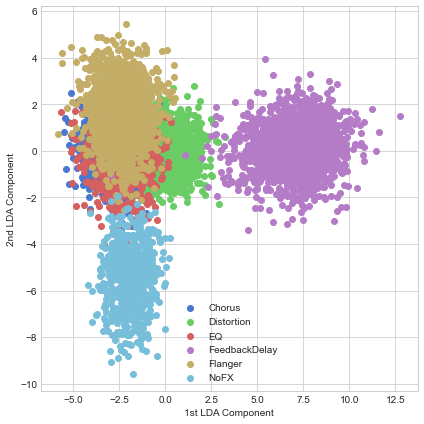

In [5]:
# Construct a LDA object
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

# Train the LDA with labeled features
lda.fit(features, labels)

# Create projected feature set by transforming the features via LDA
projected_features = lda.transform(features)

#Plot the first two LDA components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 1],
                    projected_features[labels==lab_val, 2],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

## 4. SVM Classifier 
This block runs the Support Vector Machine classifier with Linear Discriminant Analysis with the split and scaled data and outputs some metrics. You can also save and load a pretrained model file running block 5.a.a and 5.a.b

In [6]:
from sklearn.model_selection import train_test_split

# split the dataset into training and testing data
proj_feat_train, proj_feat_test, lab_train, lab_test = train_test_split(projected_features, labels, test_size=0.2, random_state=7)

In [7]:
# Construct a scaler object
scaler = sklearn.preprocessing.StandardScaler()

# Train scaler using training data
scaler.fit(proj_feat_train)

# Scale training data and test data using the scaler
feat_train = scaler.transform(proj_feat_train)
feat_test = scaler.transform(proj_feat_test)

In [8]:
#Creating an instance of a SVM classifier
model_SVM = sklearn.svm.SVC(kernel='rbf', C=2.0, verbose=True)

#training the model
model_SVM.fit(proj_feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = model_SVM.predict(proj_feat_test)

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

[LibSVM]Number of mislabeled samples 48 out of 1872
Accuracy: 0.9743589743589743


              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       377
         1.0       1.00      1.00      1.00       391
         2.0       0.97      0.99      0.98       242
         3.0       1.00      1.00      1.00       363
         4.0       0.96      0.93      0.94       378
         5.0       1.00      1.00      1.00       121

    accuracy                           0.97      1872
   macro avg       0.98      0.98      0.98      1872
weighted avg       0.97      0.97      0.97      1872



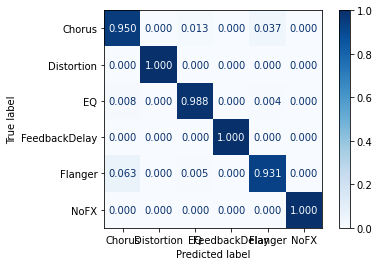

In [9]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

disp = sklearn.metrics.plot_confusion_matrix(model_SVM, proj_feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize="true", values_format=".3f")

## 5. ANN Classifier

### 5.a No dimensionality reduction 
This block runs the MultiLayer Perceptron (without dimensionality reduction) with the split and scaled data and outputs some metrics. You can also save and load a pretrained model file running block 5.a.a and 5.a.b

In [10]:
from sklearn.model_selection import train_test_split

# split the dataset into training and testing data
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=7)

In [11]:
# Construct a scaler object
scaler = sklearn.preprocessing.StandardScaler()

# Train scaler using training data
scaler.fit(feat_train)

# Scale training data and test data using the scaler
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

Accuracy: 0.9396367521367521


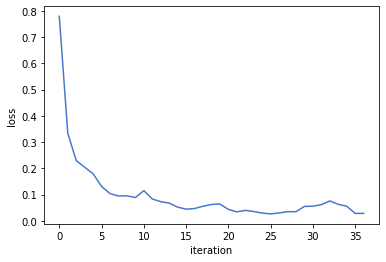

Number of mislabeled samples 113 out of 1872
Accuracy: 0.9396367521367521
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       377
         1.0       1.00      1.00      1.00       391
         2.0       0.97      0.98      0.97       242
         3.0       0.99      0.98      0.99       363
         4.0       0.87      0.89      0.88       378
         5.0       0.98      0.97      0.97       121

    accuracy                           0.94      1872
   macro avg       0.95      0.94      0.95      1872
weighted avg       0.94      0.94      0.94      1872



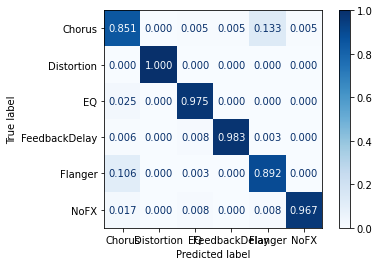

In [12]:
from sklearn.neural_network import MLPClassifier

# Construct MultiLayer Perceptron object
mlp = MLPClassifier(hidden_layer_sizes=(100,50,100), max_iter=10000, activation='relu', verbose=False)

# Train the MLP using the training data
mlp.fit(feat_train, lab_train)

# Run the model on the test data to get an accuracy score
lab_predict = mlp.predict(feat_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Print out metrics and plot a pretty confusion matrix
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
disp = sklearn.metrics.plot_confusion_matrix(mlp, feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize="true", values_format=".3f")

#### 5.a.a Save trained model

In [ ]:
# Save the model
dump(mlp, 'mlp.joblib')

#### 5.a.b Load trained model

In [13]:
# Load the model and run a quick test
mlp = load('mlp.joblib')
lab_predict = mlp.predict(feat_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Accuracy: 0.9465811965811965


### 5.b With dimensionality reduction
This block runs the MultiLayer Perceptron (with dimensionality reduction) with the split and scaled data and outputs some metrics. You can also save and load a pretrained model file running block 5.b.a and 5.b.b

In [14]:
from sklearn.model_selection import train_test_split

# split the dataset into training and testing data
proj_feat_train, proj_feat_test, lab_train, lab_test = train_test_split(projected_features, labels, test_size=0.2, random_state=7)

In [15]:
# Construct a scaler object
scaler = sklearn.preprocessing.StandardScaler()

# Train scaler using training data
scaler.fit(proj_feat_train)

# Scale training data and test data using the scaler
feat_train = scaler.transform(proj_feat_train)
feat_test = scaler.transform(proj_feat_test)

In [ ]:
from sklearn.neural_network import MLPClassifier

# Construct MultiLayer Perceptron object
mlp = MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu', verbose=False)

# Train the MLP using the training data
mlp.fit(proj_feat_train, lab_train)

# Run the model on the test data to get an accuracy score
lab_predict = mlp.predict(proj_feat_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# Print out metrics and plot a pretty confusion matrix
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
disp = sklearn.metrics.plot_confusion_matrix(mlp, proj_feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize="true", values_format=".3f")

#### 5.b.a Save trained model

In [ ]:
# Save the model
dump(mlp, 'mlp_lda.joblib')

#### 5.b.b Load trained model

In [16]:
# Load the model and run a quick test
mlp = load('mlp_lda.joblib')
lab_predict = mlp.predict(proj_feat_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Accuracy: 0.9706196581196581


## 6. K-Fold Cross Validation
This section runs a stratified K-fold cross validation on the different configurations


### 6.a SVM - With dimensionality reduction

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
pipe = Pipeline([('lda', LinearDiscriminantAnalysis()),
                 ('scaler', StandardScaler()),
                 ('classifier', SVC(kernel='rbf', C=2.0, verbose=True))
                ])

skf = sklearn.model_selection.StratifiedKFold()
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=skf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

### 6.b MLP - No dimensionality reduction

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('scaler', StandardScaler()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(100,50,100), max_iter=10000, activation='relu', verbose=False))
                ])

skf = sklearn.model_selection.StratifiedKFold()
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=skf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

### 6.c MLP - With dimensionality reduction

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe = Pipeline([('lda', LinearDiscriminantAnalysis()),
                 ('scaler', StandardScaler()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu', verbose=False))
                ])

skf = sklearn.model_selection.StratifiedKFold()
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=skf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

## 7. Repeated K-Fold Cross Validation
This section runs the final repeated stratified K-fold cross validation used to compare the different configurations. These operations obviously takes a long time to run.

### 7.a SVC with dimensionality reduction

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
pipe = Pipeline([('lda', LinearDiscriminantAnalysis()),
                 ('scaler', StandardScaler()),
                 ('classifier', SVC(kernel='rbf', C=2.0, verbose=True))
                ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=rskf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

### 7.b MLP - no dimensionality reduction

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('scaler', StandardScaler()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(100,50,100), max_iter=10000, activation='relu', verbose=False))
                ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=rskf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

### 7.b With dimensionality reduction

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lda', LinearDiscriminantAnalysis()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu', verbose=False))
                ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=rskf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

## 8. Grid search
This section is just to show how I implemented the grid search. The grid parameters for both blocks have been changed multiple times over the course of this project, to estimate multiple different hyperparameters.

### 8.a SVM parameter search

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipe = Pipeline([('scaler', StandardScaler()),
                 ('lda', LinearDiscriminantAnalysis()),
                 ('classifier', SVC())])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
grid_params = {
    'classifier__C':[2,3,4,5]
}

grid_search = sklearn.model_selection.GridSearchCV(estimator=pipe, param_grid=grid_params, scoring='accuracy', cv=rskf, n_jobs=-1)
grid_search.fit(features,labels)

print('best set of parameters', grid_search.best_params_)
print('associated best score',grid_search.best_score_)      

### 8.b MLP parameter search

In [ ]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe = Pipeline([('scaler', StandardScaler()),
                 #('lda', LinearDiscriminantAnalysis()),
                 ('classifier', MLPClassifier(hidden_layer_sizes=(10,5,10), max_iter=10000, activation='relu'))
                ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
grid_params = {
    'classifier__hidden_layer_sizes':[(10,5,10),(100,50,100),(1000,500,1000)]
}
                                                       
grid_search = sklearn.model_selection.GridSearchCV(estimator=pipe, param_grid=grid_params, scoring='accuracy',cv=rskf,n_jobs=-1)
grid_search.fit(features, labels)
                                                       
print('best set of parameters', grid_search.best_params_)
print('associated best score',grid_search.best_score_)                                                       
                                                       